# Overview

This Jupyter notebook predicts large-area tiles downloaded in `4a-download-large-area` with a trained model from `3-model-master`. The notebook is broken down into the following sections:

   * **Model loading**:
   * **Coordinate identification**
   * **Tiling**
   * **Loading and predicting**
   * **Mosaicing**
   * **Writing TIF**
   * **Writing COG**

# 1.0 Package imports

In [1]:
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
from osgeo import ogr, osr
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import rasterio
from rasterio.transform import from_origin
from tqdm import tnrange, tqdm_notebook
from scipy.ndimage import median_filter
from skimage.transform import resize
import hickle as hkl
from time import sleep

%run ../src/downloading/utils.py
%run ../src/models/utils.py

Using TensorFlow backend.


# 1.1 Parameter definitions

# 2.0 Model loading

In [357]:
path = '../models/master-2021-13000/'
new_saver = tf.train.import_meta_graph(path + 'model.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(path))

In [358]:
for i in range(50):
    try:
        logits = tf.get_default_graph().get_tensor_by_name("conv2d_{}/Sigmoid:0".format(i))
    except Exception:
        pass
    
inp = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
length = tf.get_default_graph().get_tensor_by_name("Placeholder_1:0")


#inp_median = tf.get_default_graph().get_tensor_by_name("Placeholder_4:0")
rmax = tf.get_default_graph().get_tensor_by_name("Placeholder_4:0")
rmin = tf.get_default_graph().get_tensor_by_name("Placeholder_5:0")
dmax = tf.get_default_graph().get_tensor_by_name("Placeholder_6:0")

## 2.2 Tiling functions

In [359]:
%run ../src/models/utils.py
def fspecial_gauss(size, sigma):

    """Function to mimic the 'fspecial' gaussian MATLAB function
    """

    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g

arr = fspecial_gauss(14, 4.5)
arr = arr[:7, :7]

SIZE = 10
SIZE_N = SIZE*SIZE
SIZE_UR = (SIZE - 1) * (SIZE - 1)
SIZE_R = (SIZE - 1) * SIZE
SIZE_U = SIZE_R
TOTAL = SIZE_N + SIZE_UR + SIZE_R + SIZE_U
print(SIZE_N, SIZE_UR, SIZE_R, SIZE_U, TOTAL)

arr = np.concatenate([arr, np.flip(arr, 0)], 0)
base_filter = np.concatenate([arr, np.flip(arr, 1)], 1)
normal = np.tile(base_filter, (SIZE, SIZE))
normal[:, 0:7] = 1.
normal[:, -7:] = 1.
normal[0:7, :] = 1.
normal[-7:, :] = 1.
upright = np.tile(base_filter, (SIZE - 1, SIZE - 1))
upright = np.pad(upright, (7, 7), 'constant', constant_values = 0)
right_filter = np.tile(base_filter, (SIZE, SIZE - 1))
right_filter = np.pad(right_filter, ((0, 0), (7, 7)), 'constant', constant_values = 0)
up_filter = np.tile(base_filter, (SIZE - 1, SIZE))
up_filter = np.pad(up_filter, ((7, 7), (0, 0)), 'constant', constant_values = 0)

sums = (upright + normal)# + up_filter + right_filter
#up_filter /= sums
#right_filter /= sums
upright /= sums
normal /= sums

100 81 90 90 361


# 2.3 Prediction functions

In [360]:
# 12700
min_all = [0.012558175020981156, 0.025696192874036773, 0.015518425268940261, 0.04415960936903945, 0.040497444113832305, 0.04643320363164721, 0.04924086366063935, 0.04289311055161364, 0.027450980392156862, 0.019760433356221865, 0.0, 0.5432562150454495, 0.2969113383797463, -0.03326967745787883, -0.4014989586557378, -0.023132966289995487, -0.4960341058778109]
max_all = [0.21116960402838178, 0.30730144197756926, 0.4478065156023499, 0.5342488746471351, 0.4942702372777905, 0.5072556649118791, 0.5294422827496758, 0.5418631265735866, 0.6813458457312886, 0.6285648889906157, 0.4208438239108873, 0.9480767549203932, 0.8130214090572532, 0.7444347421954634, 0.3268904303046983, 0.6872429594867983, 0.7129084148772861]


In [438]:
import copy
%run ../src/models/utils.py


x = 432
y = 1198
data = pd.read_csv("final_processing_area_noclip.csv")

data = data[data['Y_tile'] == int(y)]
data = data[data['X_tile'] == int(x)]

y = str(y)
x = str(x)


def make_bbox(initial_bbx, expansion = 10):
    
    multiplier = 1/360
    bbx = copy.deepcopy(initial_bbx)
    bbx[0] -= expansion * multiplier
    bbx[1] -= expansion * multiplier
    bbx[2] += expansion * multiplier
    bbx[3] += expansion * multiplier
    return bbx



data = data.reset_index(drop = True)
if ".0" in x:
    x = x[:-2]
if ".0" in y:
    y = y[:-2]

initial_bbx = [data['X'][0], data['Y'][0], data['X'][0], data['Y'][0]]
point = make_bbox(initial_bbx, expansion = 300/30)
print(point)


inp_folder = f'../project-monitoring/tof/{str(x)}/{str(y)}/processed/'
out_folder = f'../project-monitoring/tof/{str(x)}/{str(y)}/output/'

[-85.99999999999908, 13.111111111110523, -85.94444444444353, 13.16666666666608]


<Figure size 432x288 with 0 Axes>

In [439]:


def convert_to_db(x, min_db):
    x = 10 * np.log10(x + 1/65535)
    x[x < -min_db] = -min_db
    x = x + min_db
    x = x / min_db
    x = np.clip(x, 0, 1)
    return x

def grndvi(array):
    nir = np.clip(array[..., 3], 0, 1)
    green = np.clip(array[..., 1], 0, 1)
    red = np.clip(array[..., 2], 0, 1)
    denominator = (nir+(green+red)) + 1e-5
    return (nir-(green+red)) / denominator

def evi(x: np.ndarray, verbose: bool = False) -> np.ndarray:
    '''
    Calculates the enhanced vegetation index
    2.5 x (08 - 04) / (08 + 6 * 04 - 7.5 * 02 + 1)
    '''

    BLUE = x[..., 0]
    GREEN = x[..., 1]
    RED = x[..., 2]
    NIR = x[..., 3]
    evis = 2.5 * ( (NIR-RED) / (NIR + (6*RED) - (7.5*BLUE) + 1))
    evis = np.clip(evis, -1.5, 1.5)
    return evis

def msavi2(x: np.ndarray, verbose: bool = False) -> np.ndarray:
    '''
    Calculates the modified soil-adjusted vegetation index 2
    (2 * NIR + 1 - sqrt((2*NIR + 1)^2 - 8*(NIR-RED)) / 2
    '''
    BLUE = x[..., 0]
    GREEN = x[..., 1]
    RED = np.clip(x[..., 2], 0, 1)
    NIR = np.clip(x[..., 3], 0, 1)

    msavis = (2 * NIR + 1 - np.sqrt( (2*NIR+1)**2 - 8*(NIR-RED) )) / 2
    return msavis

def bi(x: np.ndarray, verbose: bool = False) -> np.ndarray:
    B11 = np.clip(x[..., 8], 0, 1)
    B4 = np.clip(x[..., 2], 0, 1)
    B8 = np.clip(x[..., 3], 0, 1)
    B2 = np.clip(x[..., 0], 0, 1)
    bis = ((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2))
    return bis


            

def load_and_predict_folder(pred_files, overlap_filter = upright,
                            normal_filter = normal, histogram_match = False):
    """Insert documentation here
    """
      
    clipping_params = {
        'rmax': rmax,
        'rmin': rmin,
        'dmax': dmax
    }
    
    pred_x = []
    x = hkl.load(pred_files)
    
        
    if np.sum(x) > 0:
        if not isinstance(x.flat[0], np.floating):
            assert np.max(x) > 1
            x = x / 65535.

        x[..., -1] = convert_to_db(x[..., -1], 50)
        x[..., -2] = convert_to_db(x[..., -2], 50)

        indices = np.empty((12, x.shape[1], x.shape[2], 4))
        indices[..., 0] = evi(x)
        indices[..., 1] = bi(x)
        indices[..., 2] = msavi2(x)
        indices[..., 3] = grndvi(x)

        x = np.concatenate([x, indices], axis = -1)

        med = np.median(x, axis = 0)
        med = med[np.newaxis, :, :, :]
        x = np.concatenate([x, med], axis = 0)

        filtered = median_filter(x[0, :, :, 10], size = 5)
        x[:, :, :, 10] = np.stack([filtered] * x.shape[0])
        x = tile_images(x)
        
        pred_x = np.stack(x)   
        for band in range(0, pred_x.shape[-1]):
            mins = min_all[band]
            maxs = max_all[band]
            pred_x[..., band] = np.clip(pred_x[..., band], mins, maxs)
            midrange = (maxs + mins) / 2
            rng = maxs - mins
            standardized = (pred_x[..., band] - midrange) / (rng / 2)
            pred_x[..., band] = standardized

        preds = []
        batches = [x for x in range(0, 180, 40)] + [181]
        for i in range(len(batches)-1):
            batch_x = pred_x[batches[i]:batches[i+1]]
            lengths = np.full((batch_x.shape[0], 1), 12)
            batch_pred = sess.run(logits,
                                  feed_dict={inp:batch_x, 
                                             clipping_params['rmax']: 5,
                                             clipping_params['rmin']: 0,
                                             clipping_params['dmax']: 3,
                                             length:lengths}).reshape(batch_x.shape[0], 14, 14)
            for sample in range(batch_pred.shape[0]):
                preds.append(batch_pred[sample, :, :])


        preds_stacked = []
        for i in range(0, SIZE_N, SIZE):
            preds_stacked.append(np.concatenate(preds[i:i + SIZE], axis = 1))
        stacked = np.concatenate(preds_stacked, axis = 0) * normal

        preds_overlap = []
        for scene in range(SIZE_N, SIZE_N+SIZE_UR, SIZE - 1):
            to_concat = np.concatenate(preds[scene:scene+ (SIZE - 1)], axis = 1)
            preds_overlap.append(to_concat)    
        overlapped = np.concatenate(preds_overlap, axis = 0)
        overlapped = np.pad(overlapped, (7, 7), 'constant', constant_values = 0)
        overlapped = overlapped * upright


        stacked = stacked + overlapped# + right + up
    else:
        stacked = np.full((140, 140), 255)
    
    return stacked
    '''
    preds_up = []
    for scene in range(SIZE_N+SIZE_UR, SIZE_N+SIZE_UR+SIZE_R, SIZE):
        to_concat = np.concatenate(preds[scene:scene+SIZE], axis = 1)
        preds_up.append(to_concat)   
    up = np.concatenate(preds_up, axis = 0)
    up = np.pad(up, ((7,7), (0,0)), 'constant', constant_values = 0)
    up = up * up_filter
        
    preds_right = []
    for scene in range(SIZE_N+SIZE_UR+SIZE_R, TOTAL, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+SIZE-1], axis = 1)
        preds_right.append(to_concat)   
    right = np.concatenate(preds_right, axis = 0)
    right = np.pad(right, ((0, 0), (7, 7)), 'constant', constant_values = 0)
    right = right * right_filter
    '''

# Development Code

# 2.4 Run predictions

In [440]:
def tile_images(arr: np.ndarray) -> list:
    """ Converts a 142x142 array to a 289, 24, 24 array
        
        Parameters:
         arr (np.ndaray): (142, 142) float array
    
        Returns:
         images (list): 
    """

    # Normal
    images = []
    for x_offset, cval in enumerate([x for x in range(0, 140, 14)]):
        for y_offset, rval in enumerate([x for x in range(0, 140, 14)]):
            min_x = np.max([cval - 0, 0])
            max_x = np.min([cval + 24, 150])
            min_y = np.max([rval - 0, 0])
            max_y = np.min([rval + 24, 150])
            subs = arr[:, min_x:max_x, min_y:max_y]
            images.append(subs)
            
    # Upright  
    for x_offset, cval in enumerate([x for x in range(7,  140-7, 14)]):
        for y_offset, rval in enumerate([x for x in range(7, 140-7, 14)]):
            base_id = 9*9
            min_x = np.max([cval - 0, 0])
            max_x = np.min([cval + 24, 150])
            min_y = np.max([rval - 0, 0])
            max_y = np.min([rval + 24, 150])
            subs = arr[:, min_x:max_x, min_y:max_y]
            images.append(subs)

    return images

In [441]:
from time import time
time1 = time()

x_tiles = [int(x) for x in os.listdir(inp_folder) if '.DS' not in x]
max_x = np.max(x_tiles) + 140

for x_tile in x_tiles:
    y_tiles = [int(y[:-4]) for y in os.listdir(inp_folder + str(x_tile) + "/") if '.DS' not in y]
    max_y = np.max(y_tiles) + 140
    for y_tile in y_tiles:
        output_file = f"{out_folder}{str(x_tile)}/{str(y_tile)}.npy"
        input_file = f"{inp_folder}{str(x_tile)}/{str(y_tile)}.hkl"
        if os.path.exists(input_file) and not os.path.exists(output_file):
            print(output_file)
            prediction = load_and_predict_folder(input_file, histogram_match = False)
            print(prediction.shape)
            if not os.path.exists(f"{out_folder}{str(x_tile)}/"):
                os.makedirs(f"{out_folder}{str(x_tile)}/")
            prediction = prediction
            np.save(output_file, prediction)
            
time2 = time()
print(f"Finished in {np.around(time2 - time1, 1)} seconds")

../project-monitoring/tof/432/1198/output/462/238.npy
(140, 140)
../project-monitoring/tof/432/1198/output/462/358.npy
(140, 140)
../project-monitoring/tof/432/1198/output/462/119.npy
(140, 140)
../project-monitoring/tof/432/1198/output/462/478.npy
(140, 140)
../project-monitoring/tof/432/1198/output/462/0.npy
(140, 140)
../project-monitoring/tof/432/1198/output/346/238.npy
(140, 140)
../project-monitoring/tof/432/1198/output/346/358.npy
(140, 140)
../project-monitoring/tof/432/1198/output/346/119.npy
(140, 140)
../project-monitoring/tof/432/1198/output/346/478.npy
(140, 140)
../project-monitoring/tof/432/1198/output/346/0.npy
(140, 140)
../project-monitoring/tof/432/1198/output/0/238.npy
(140, 140)
../project-monitoring/tof/432/1198/output/0/358.npy
(140, 140)
../project-monitoring/tof/432/1198/output/0/119.npy
(140, 140)
../project-monitoring/tof/432/1198/output/0/478.npy
(140, 140)
../project-monitoring/tof/432/1198/output/0/0.npy
(140, 140)
../project-monitoring/tof/432/1198/output


# 2.5 Mosaic predictions

In [442]:
if not (max_x or max_y):
    x_tiles = [int(x) for x in os.listdir(out_folder) if '.DS' not in x]
    max_x = np.max(x_tiles) + 140

    for x_tile in x_tiles:
        y_tiles = [int(y[:-4]) for y in os.listdir(out_folder + str(x_tile) + "/") if '.DS' not in y]
        max_y = np.max(y_tiles) + 140

predictions = np.full(
    (max_x,
     max_y), 0, dtype = np.uint8 )

x_tiles = [int(x) for x in os.listdir(out_folder) if '.DS' not in x]

for x_tile in x_tiles:
    y_tiles = [int(y[:-4]) for y in os.listdir(out_folder + str(x_tile) + "/") if '.DS' not in y]
    for y_tile in y_tiles:
        output_file = out_folder + str(x_tile) + "/" + str(y_tile) + ".npy"
        if os.path.exists(output_file):
            prediction = np.load(output_file)
            prediction = prediction * 100
            predictions[(x_tile ): (x_tile+140),
                       y_tile:y_tile + 140] = prediction.T.astype(np.uint8)

In [443]:
for x_i in range(0, predictions.shape[0] - 3):
    for y_i in range(0, predictions.shape[1] - 3):
        window = predictions[x_i:x_i+3, y_i:y_i+3]
        if np.max(window) < 50:
            if np.sum(np.logical_and(window > 20, window < 60)) > 4:
                 predictions[x_i:x_i+3, y_i:y_i+3] = 0.
            #if np.sum(np.logical_and(window > 10, window < 30)) > 4:
            #     predictions[x_i:x_i+3, y_i:y_i+3] = 0.

                    
predictions = np.around(predictions / 10, 0) * 10
predictions[predictions < .25*100] = 0.
        

In [444]:
predictions = np.around(predictions / 10, 0) * 10
#predictions[predictions < .25*100] = 0.

#### 2.6 Sharpen predictions

In [445]:
def recover_new(arr, thresh):
    """Not currently used. Identifies small trees that may be below the
       threshold for binary map creation.
    """
    adding = 0
    stacked = np.copy(arr)
    for window_x in tnrange(2, stacked.shape[0]-2, 1):
        for window_y in range(2, stacked.shape[1]-2, 1):
            #
            five_w = stacked[window_x-2:window_x+3, window_y-2:window_y+3]
            three_w = stacked[window_x-1:window_x+2, window_y-1:window_y+2]
            
            n_five_above = len(five_w[np.argwhere(five_w > 0.15)])
            n_three_above = len(three_w[np.argwhere(three_w > 0.15)])
            
            n_five_below = len(five_w[np.argwhere(five_w < thresh)])
            
            
            if n_five_below >= 24:                 
                # if less than 2 of the 5x5 are positive
                if n_three_above >= 2 and n_three_above < 6:            
                    # and at least 2 of the 3x3 are above 0.1
                    if n_three_above <= (n_five_above + 4):  
                        # and less than 1/4 of the outer border is above 0.1
                        if np.argmax(three_w) == 4:          
                            # and the center of the 3 x 3 is the largest
                            stacked[window_x, window_y] = -1.
                            adding += 1
    stacked[np.where(stacked == -1)] = 1.
    return stacked

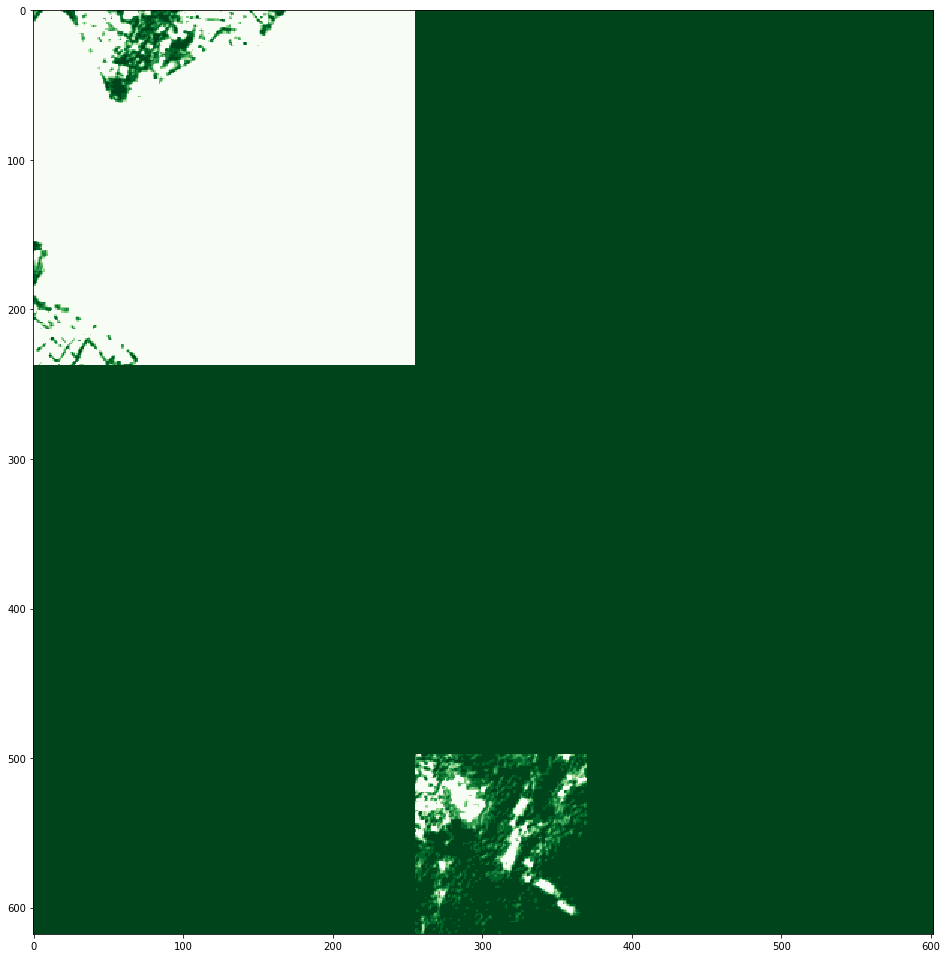

In [446]:
stacked = predictions
stacked[stacked == 160] = 255.

plot = True
if plot:
    plt.figure(figsize=(20,17))
    plt.imshow(stacked.T, cmap='Greens', vmin=0, vmax=100)
    plt.show()

# 3.0 Write GeoTiff

In [447]:
file = out_folder[:-7] + f"{str(x)}X{str(y)}Y_POST.tif"

west = point[0]
east = point[2]
north = point[3]
south = point[1]

arr = stacked.T.astype(np.uint8)

transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = arr.shape[1], 
                                           height = arr.shape[0])

print("Writing", file)
new_dataset = rasterio.open(file, 'w', driver = 'GTiff',
                           height = arr.shape[0], width = arr.shape[1], count = 1,
                           dtype = "uint8",
                           crs = '+proj=longlat +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(arr, 1)
new_dataset.close()

Writing ../project-monitoring/tof/432/1198/432X1198Y_POST.tif


In [249]:
!gdal_translate ../../ce-hosting/includes/niger-koure.tif ../tile_data/cog/niger-koure.tif \
               -co TILED=YES -co COMPRESS=LZW
!gdaladdo -r average -ro ../tile_data/cog/niger-koure.tif 2 4 8 16

ERROR 4: ../../ce-hosting/includes/niger-koure.tif: No such file or directory
0...10...20...30...40...50...60...70...80...90...100 - done.


In [212]:
import os
from osgeo import gdal
from glob import glob
li_dirs = "colombia/"


print(li_dirs)
li_all_files = list()

files = [file for file in os.listdir('colombia/')  if os.path.splitext(file)[-1] == '.tif']
print(files)
for file in files:
    li_all_files.append(os.path.join("colombia/", file))

gdal.BuildVRT('colombia.vrt', li_all_files)

!gdal_translate -of GTiff colombia.vrt colombia.tif -ot Byte -co compress=LZW 

KeyboardInterrupt: 

# 3.2 One-hectare tree cover Geotiff

In [ ]:
summed = np.reshape(stacked, (stacked.shape[0] // 10, 10, stacked.shape[1] // 10, 10))
summed = np.mean(summed, (1, 3))

summed = summed.astype(np.float32)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = summed.shape[1], height = summed.shape[1])

new_dataset = rasterio.open('../../ce-hosting/includes/bonanza1.tif', 'w', driver = 'GTiff',
                           height = summed.shape[1], width = summed.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(summed, 1)
new_dataset.close()